In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader

torch.manual_seed(611)

In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values#.argmax(1)
etiquetasN = torch.tensor(Clases)

In [4]:
features = 'VGGish'#'PANNs'#'YAMNet' #'VGGish'#'AI'

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

RZUA01
Data1.shape=torch.Size([3, 24, 128])
RZUA02
Data1.shape=torch.Size([3, 24, 128])
RZUA04
Data1.shape=torch.Size([3, 24, 128])
RZUA05
Data1.shape=torch.Size([3, 24, 128])
RZUA06
Data1.shape=torch.Size([3, 24, 128])
RZUA07
Data1.shape=torch.Size([3, 24, 128])
RZUA08
Data1.shape=torch.Size([3, 24, 128])
RZUA09
Data1.shape=torch.Size([3, 24, 128])
RZUA10
Data1.shape=torch.Size([3, 24, 128])
RZUB01
Data1.shape=torch.Size([3, 24, 128])
RZUB03
Data1.shape=torch.Size([3, 24, 128])
RZUB04
Data1.shape=torch.Size([3, 24, 128])
RZUB05
Data1.shape=torch.Size([3, 24, 128])
RZUB06
Data1.shape=torch.Size([3, 24, 128])
RZUB07
Data1.shape=torch.Size([3, 24, 128])
RZUB08
Data1.shape=torch.Size([3, 24, 128])
RZUB09
Data1.shape=torch.Size([3, 24, 128])
RZUB10
Data1.shape=torch.Size([3, 24, 128])
RZUB11
Data1.shape=torch.Size([3, 24, 128])
RZUC01
Data1.shape=torch.Size([3, 24, 128])
RZUC02
Data1.shape=torch.Size([3, 24, 128])
RZUC03
Data1.shape=torch.Size([3, 24, 128])
RZUC05
Data1.shape=torch.Size([3

In [6]:
def min_max_normalize_along_dim(tensor, dim):
    # Get min and max values along the specified dimension, keeping dimensions
    min_vals, _ = torch.min(tensor, dim=dim, keepdim=True)
    max_vals, _ = torch.max(tensor, dim=dim, keepdim=True)
    
    # Handle the case where min and max are the same (to avoid division by zero)
    diff = max_vals - min_vals
    diff[diff == 0] = 1.0  # Replace zeros with ones to avoid division by zero
    
    # Normalize the tensor
    normalized = (tensor - min_vals) / diff
    
    return normalized

In [7]:
x = min_max_normalize_along_dim(x, dim=2)
x.shape

torch.Size([3, 92, 24, 128])

## Edge Creation

In [8]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [9]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=5)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

max_nodes = max([data.num_nodes for data in graphs])
num_feat = graphs[0].x.shape[-1]
num_feat

Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True


128

In [10]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

In [11]:
del graphs, x, unpacked_data, train_dataset

## Crear modelo y entrenar

In [12]:
from models import MatrixGCNVAE_MT, MatrixGATVAE_MT

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if features =='PANNs':
    device = torch.device('cpu')
print(device)

cuda


In [14]:
etiquetasN = etiquetasN.to(device)

In [15]:
model = MatrixGCNVAE_MT(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes, num_classes=3)
model = model.to(device)
etiquetasN = etiquetasN.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #0.01 GCN

# Training function
def train():
    model.train()
    model.double()

    total_loss = 0
    total_feature_loss = 0
    total_adj_loss = 0
    total_kl_loss = 0
    total_class_loss = 0
    total_accuracy = 0
    graph_count = 0


    for graph in train_loader:
        graph = graph.to(device)

        optimizer.zero_grad()
        node_reconstruction, adj_reconstruction, mu, logvar, class_logits = model(graph.x.double(), graph.edge_index)
        loss, feature_loss, adj_loss, kl_loss, class_loss = model.loss_function(node_reconstruction, adj_reconstruction, class_logits, etiquetasN, graph.x.double(),
                                                                    graph.edge_index, mu, logvar, alpha=1.0, beta=0.1)
        loss.backward()
        optimizer.step()
        accuracy = F.softmax(class_logits, dim=1).argmax(dim=1).eq(etiquetasN.argmax(dim=1)).sum()

        # Acumular métricas si deseas promediarlas después
        total_loss += loss.item()
        total_feature_loss += feature_loss.item()
        total_adj_loss += adj_loss.item()
        total_kl_loss += kl_loss.item()
        total_class_loss += class_loss.item()
        total_accuracy += accuracy.item()
        graph_count += 1
        # print(f'{F.softmax(class_logits, dim=1).argmax(dim=1)=}, {etiquetasN.argmax(dim=1)=}')
    avg_loss = total_loss / graph_count
    avg_feature_loss = total_feature_loss / graph_count
    avg_adj_loss = total_adj_loss / graph_count
    avg_kl_loss = total_kl_loss / graph_count
    avg_class_loss = total_class_loss / graph_count
    avg_accuracy = total_accuracy / graph_count
    
    return avg_loss, avg_feature_loss, avg_adj_loss, avg_kl_loss, avg_class_loss, avg_accuracy

# Train the model
for epoch in range(1, 1001):
    loss, feature_loss, adj_loss, kl_loss, class_loss, accuracy = train()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        print(f'====> Adj loss: {adj_loss:.4f}, '
          f'Recon: {feature_loss:.4f}, KL: {kl_loss:.4f}, Class: {class_loss:.4f}, '
          f'Accuracy: {accuracy:.2f}%')

Epoch: 020, Loss: 1.7371
====> Adj loss: 0.7163, Recon: 0.0552, KL: 0.1523, Class: 0.8133, Accuracy: 67.00%
Epoch: 040, Loss: 1.6602
====> Adj loss: 0.7041, Recon: 0.0543, KL: 0.1646, Class: 0.7372, Accuracy: 76.00%
Epoch: 060, Loss: 1.6203
====> Adj loss: 0.6970, Recon: 0.0540, KL: 0.1664, Class: 0.7029, Accuracy: 79.33%
Epoch: 080, Loss: 1.5919
====> Adj loss: 0.6943, Recon: 0.0535, KL: 0.1754, Class: 0.6687, Accuracy: 81.33%
Epoch: 100, Loss: 1.5907
====> Adj loss: 0.6931, Recon: 0.0536, KL: 0.1699, Class: 0.6740, Accuracy: 80.00%
Epoch: 120, Loss: 1.5623
====> Adj loss: 0.6906, Recon: 0.0531, KL: 0.1597, Class: 0.6588, Accuracy: 81.67%
Epoch: 140, Loss: 1.5504
====> Adj loss: 0.6876, Recon: 0.0533, KL: 0.1703, Class: 0.6392, Accuracy: 80.33%
Epoch: 160, Loss: 1.5330
====> Adj loss: 0.6873, Recon: 0.0531, KL: 0.1554, Class: 0.6372, Accuracy: 82.33%
Epoch: 180, Loss: 1.5306
====> Adj loss: 0.6858, Recon: 0.0528, KL: 0.1628, Class: 0.6291, Accuracy: 84.33%
Epoch: 200, Loss: 1.5186
===

In [16]:
#save model
torch.save(model.state_dict(), f'modelsGVAE_semi/{features}_GCN_model_weights.pth')

## Eval


In [17]:
# Generate embeddings
model.eval()
with torch.no_grad():
    for graph in train_loader:
        graph = graph.to(device)
        _, _, mu, logvar, _ = model(graph.x.double(), graph.edge_index)
        embeddings = model.reparameterize(mu, logvar)

In [18]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 16])


In [19]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

## Matriz de similitud

In [20]:
embs = embeddings.cpu().numpy()
sim_mat = (embs@embs.T)/(num_feat/8)
sim_mat

array([[0.31180471, 0.26365389, 0.20107349, ..., 0.20763094, 0.25135416,
        0.28783395],
       [0.26365389, 0.30405867, 0.19711978, ..., 0.19135939, 0.26871694,
        0.28045273],
       [0.20107349, 0.19711978, 0.21046694, ..., 0.16668217, 0.19098213,
        0.24080453],
       ...,
       [0.20763094, 0.19135939, 0.16668217, ..., 0.19159575, 0.19604761,
        0.21661133],
       [0.25135416, 0.26871694, 0.19098213, ..., 0.19604761, 0.28461287,
        0.27460593],
       [0.28783395, 0.28045273, 0.24080453, ..., 0.21661133, 0.27460593,
        0.34261336]])

In [21]:
# norms = np.linalg.norm(embs, axis=1)
# sim_mat = embs @ embs.T / (norms[:, np.newaxis] @ norms[np.newaxis, :])
# sim_mat

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils import edge_index_to_adjacency

In [23]:
adj_graph = edge_index_to_adjacency(graph.cpu().edge_index)

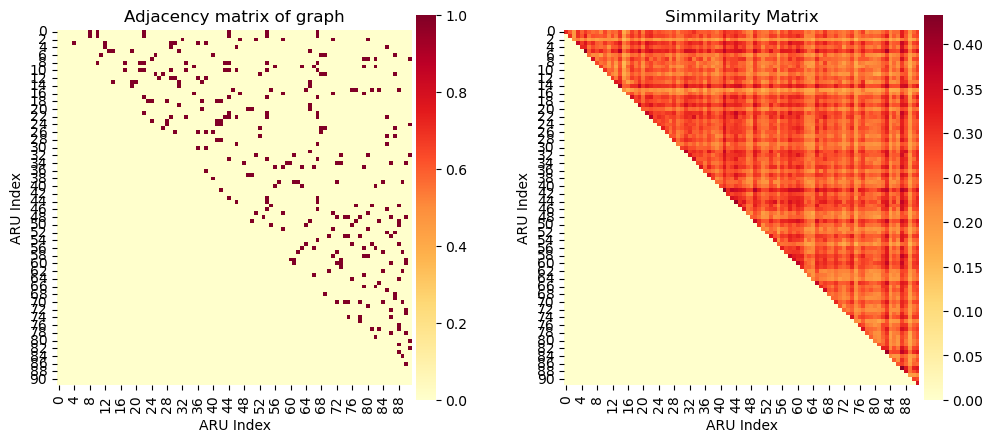

In [24]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(np.triu(adj_graph, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
sns.heatmap(np.triu(sim_mat, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Simmilarity Matrix')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

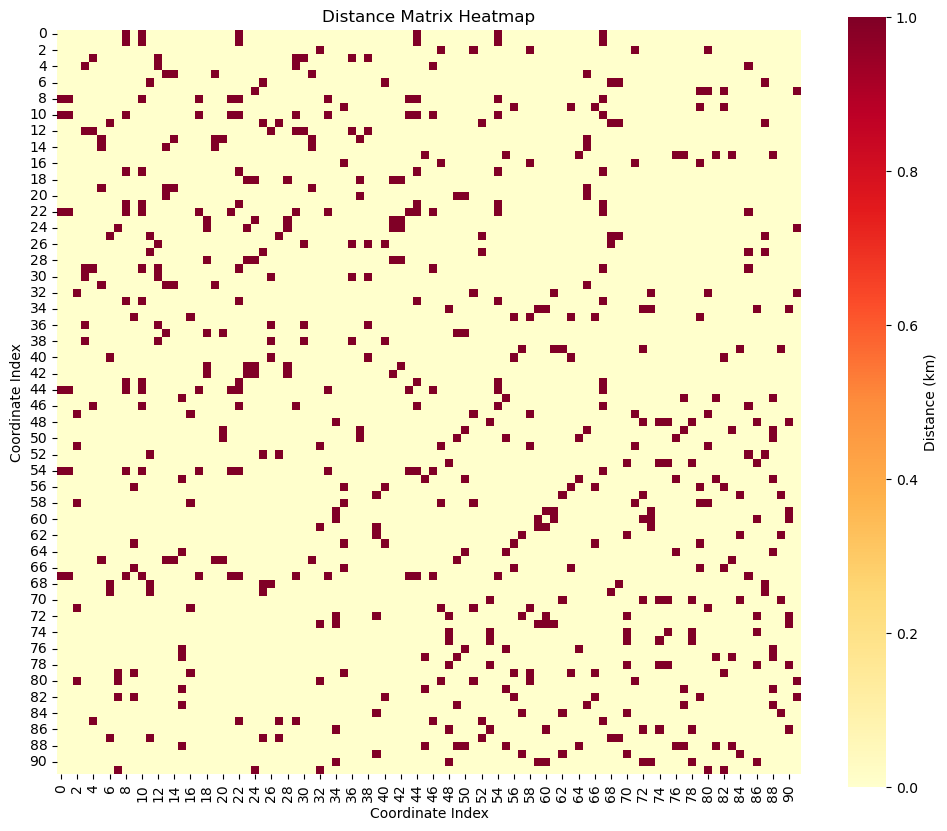

In [25]:
plot_distance_matrix_heatmap(adj_graph)

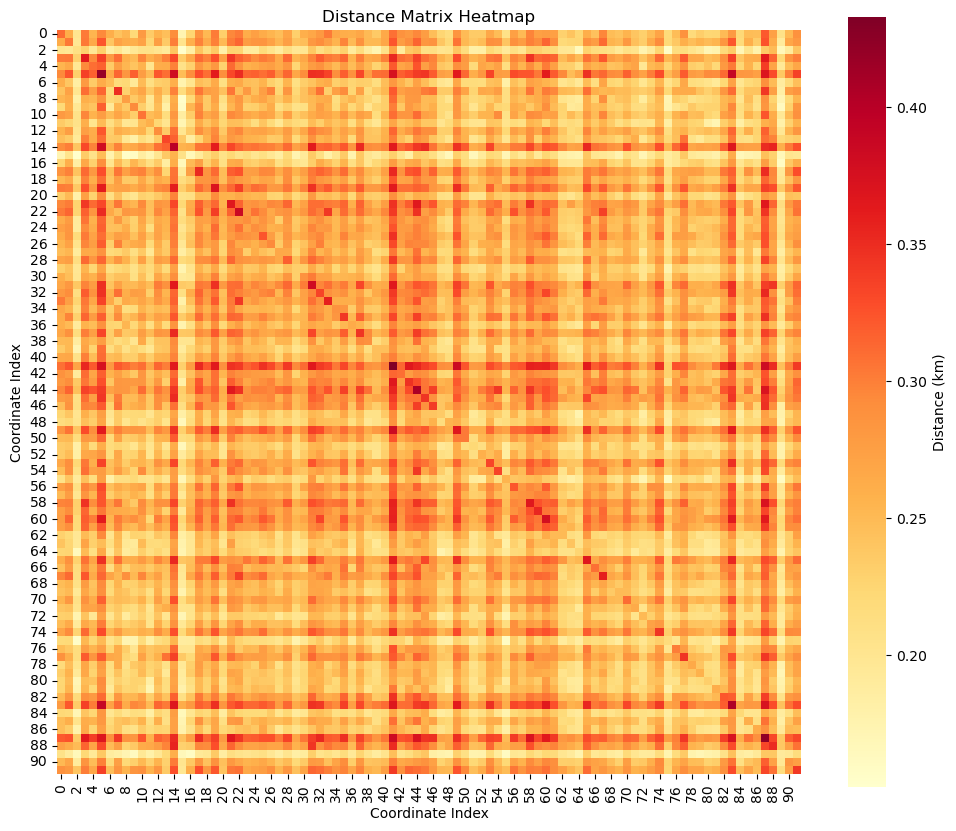

In [26]:
plot_distance_matrix_heatmap(sim_mat)

In [27]:
# density metric:

print(np.mean(sim_mat)) #axis = 0: por nodos

0.2591205316286199


In [28]:
# connectivity metric (only if thresholded):

print(np.count_nonzero(sim_mat))

8464


In [29]:
# total weight (es density sin promediar)

print(np.sum(sim_mat))

2193.1961797046392


In [30]:
def floyd_warshall(matrix):
    """Implement Floyd-Warshall algorithm for all-pairs shortest paths"""
    n = len(matrix)
    dist = np.array(matrix, dtype=float)
    
    # Replace inf with large number for calculations
    dist[dist == float('inf')] = 1e9
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    
    return dist

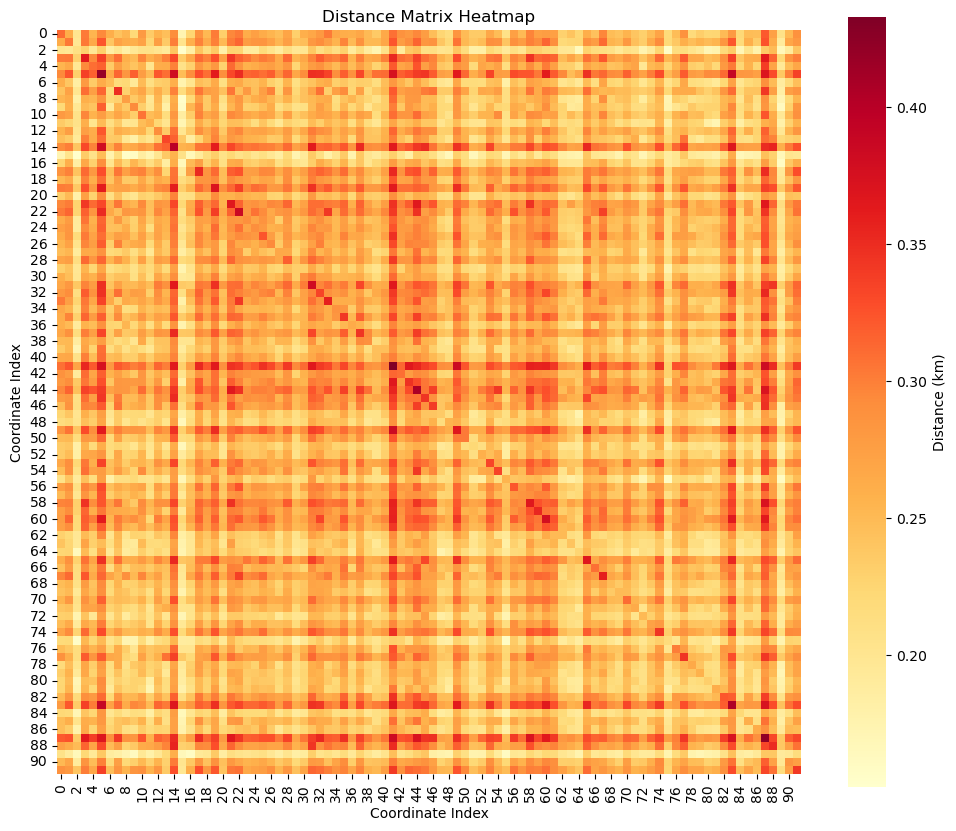

In [31]:
dist_matrix = floyd_warshall(sim_mat)
plot_distance_matrix_heatmap(dist_matrix)

In [32]:
# diameter
print(np.max(dist_matrix))

0.43283602576957214


In [33]:
#average path
print(np.mean(dist_matrix))

0.2591205316286199


In [34]:
#Betweeness centrality

n = len(dist_matrix)
centrality = np.zeros(n)
for s in range(n):
    for t in range(n):
        if s != t:
            # Count shortest paths going through each vertex
            for v in range(n):
                if v != s and v != t:
                    if dist_matrix[s][t] == dist_matrix[s][v] + dist_matrix[v][t]:
                        centrality[v] += 1
value = np.mean(centrality)
print(value)

0.0


In [35]:
dist_matrix

array([[0.31180471, 0.26365389, 0.20107349, ..., 0.20763094, 0.25135416,
        0.28783395],
       [0.26365389, 0.30405867, 0.19711978, ..., 0.19135939, 0.26871694,
        0.28045273],
       [0.20107349, 0.19711978, 0.21046694, ..., 0.16668217, 0.19098213,
        0.24080453],
       ...,
       [0.20763094, 0.19135939, 0.16668217, ..., 0.19159575, 0.19604761,
        0.21661133],
       [0.25135416, 0.26871694, 0.19098213, ..., 0.19604761, 0.28461287,
        0.27460593],
       [0.28783395, 0.28045273, 0.24080453, ..., 0.21661133, 0.27460593,
        0.34261336]])

## New tests

In [36]:
graphs_ = edge_creation_nodeinfo(embeddings.unsqueeze(0),'knn', k_neigh=5)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 16], edge_index=[2, 706]) connected? True
Is the graph undirected True


In [37]:
adj_init = edge_index_to_adjacency(graph.cpu().edge_index)
adj_final = edge_index_to_adjacency(graphs_[0].cpu().edge_index)

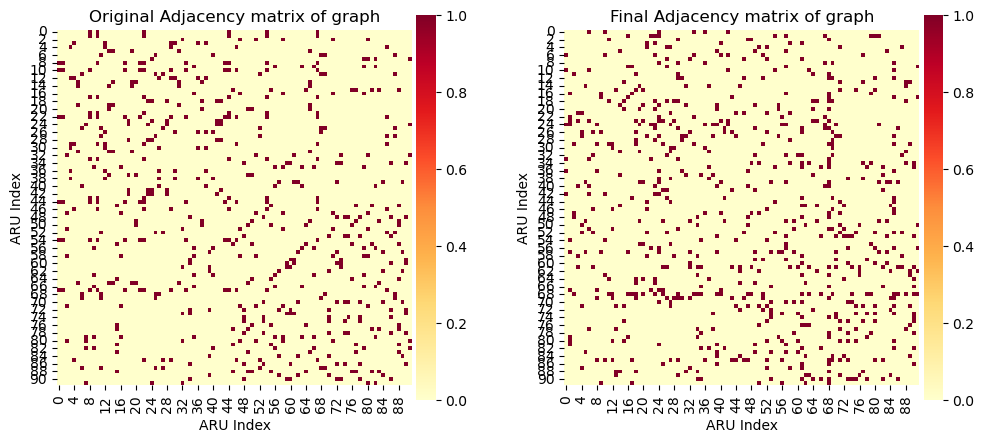

In [38]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(adj_init, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Original Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
sns.heatmap(adj_final, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Final Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

In [39]:
graphs_[0]

Data(x=[92, 16], edge_index=[2, 706])

In [40]:
graph

DataBatch(x=[92, 24, 128], edge_index=[2, 606], batch=[92], ptr=[2])

In [41]:
def pyg_to_networkx(data):
    # Convert PyG data to NetworkX graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(data.num_nodes))
    
    # Add edges with weights if available
    edges = data.edge_index.t().numpy()
    
    # Check if edge weights are available
    if hasattr(data, 'edge_weight') and data.edge_weight is not None:
        # Add edges with weights
        edge_weights = {tuple(edge): weight.item() for edge, weight in zip(edges, data.edge_weight)}
        for edge, weight in edge_weights.items():
            G.add_edge(edge[0], edge[1], weight=weight)
    else:
        # Add edges without weights
        G.add_edges_from(edges)
    
    # Optionally add node and edge attributes
    if data.x is not None:
        nx.set_node_attributes(G, {i: data.x[i].numpy() for i in range(data.num_nodes)}, 'features')
    
    if data.edge_attr is not None:
        edge_attrs = {tuple(edge): data.edge_attr[i].numpy() for i, edge in enumerate(edges)}
        nx.set_edge_attributes(G, edge_attrs, 'attributes')
    
    return G

In [42]:
import geopandas as gpd

#función que permite plotear nodos en posición geográfica deseada
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud_IG, df.latitude_IG)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

coordinates = same_posicion_data(df_map)

In [43]:
def adjacency_to_edge_weights(adj_matrix, edge_index):
    """
    Convert adjacency matrix of weights to edge_weight tensor using edge_index.
    
    Args:
        adj_matrix: Tensor of shape [num_nodes, num_nodes] containing edge weights
        edge_index: Tensor of shape [2, num_edges] containing edge indices
        
    Returns:
        edge_weight: Tensor of shape [num_edges] containing weights for each edge
    """
    # Get source and target nodes for each edge
    src, dst = edge_index[0], edge_index[1]
    
    # Extract weights from adjacency matrix based on edge indices
    edge_weight = adj_matrix[src, dst]
    
    return edge_weight

In [44]:
edge_weight = adjacency_to_edge_weights(sim_mat, graphs_[0].edge_index)
edge_weight.shape


(706,)

In [45]:
graphs_[0].edge_weight = edge_weight

In [46]:
sim_mat.shape

(92, 92)

In [47]:
import networkx as nx

G = pyg_to_networkx(graphs_[0])
nodes = list(G.nodes())
positions = dict(zip(G.nodes, coordinates))

In [48]:
G.edges(data=True)

EdgeDataView([(0, 6, {'weight': 0.26122364111911195}), (0, 10, {'weight': 0.279895383632531}), (0, 24, {'weight': 0.274017824231368}), (0, 33, {'weight': 0.30277748952876327}), (0, 36, {'weight': 0.25956765050166314}), (0, 42, {'weight': 0.2873284074931501}), (1, 16, {'weight': 0.2602429308187399}), (1, 22, {'weight': 0.3140176790486464}), (1, 23, {'weight': 0.2781875295643622}), (1, 24, {'weight': 0.28436387492513443}), (1, 54, {'weight': 0.2870220073605427}), (1, 57, {'weight': 0.2774688033068945}), (1, 67, {'weight': 0.31207669670906546}), (1, 79, {'weight': 0.25709576195251976}), (1, 80, {'weight': 0.2494544539223091}), (1, 81, {'weight': 0.25471635726611597}), (2, 11, {'weight': 0.20671754036126597}), (2, 29, {'weight': 0.197498440771658}), (2, 47, {'weight': 0.20113388969965762}), (2, 48, {'weight': 0.20425579402293287}), (2, 68, {'weight': 0.20866822897895934}), (3, 21, {'weight': 0.3423053261820522}), (3, 23, {'weight': 0.306449938459324}), (3, 40, {'weight': 0.2999025470426220

In [49]:
nx.diameter(G,weight="weight")

1.1261155815789858

In [50]:
nx.density(G)

0.08432871476349738

In [51]:
nx.average_shortest_path_length(G,weight="weight")

0.6350498030620063

In [52]:
nx.betweenness_centrality(G, weight="weight")

{0: 0.0014652014652014652,
 1: 0.016605616605616606,
 2: 0.002442002442002442,
 3: 0.002442002442002442,
 4: 0.003907203907203907,
 5: 0.0009768009768009768,
 6: 0.017582417582417582,
 7: 0.0004884004884004884,
 8: 0.00757020757020757,
 9: 0.003907203907203907,
 10: 0.009523809523809525,
 11: 0.003418803418803419,
 12: 0.002197802197802198,
 13: 0.0014652014652014652,
 14: 0.002442002442002442,
 15: 0.016361416361416362,
 16: 0.010989010989010988,
 17: 0.001221001221001221,
 18: 0.01978021978021978,
 19: 0.006105006105006105,
 20: 0.01807081807081807,
 21: 0.003418803418803419,
 22: 0.0007326007326007326,
 23: 0.0315018315018315,
 24: 0.04786324786324786,
 25: 0.014896214896214895,
 26: 0.0231990231990232,
 27: 0.04908424908424908,
 28: 0.003418803418803419,
 29: 0.05128205128205128,
 30: 0.0017094017094017094,
 31: 0.003418803418803419,
 32: 0.00757020757020757,
 33: 0.006837606837606838,
 34: 0.016361416361416362,
 35: 0.006837606837606838,
 36: 0.007814407814407814,
 37: 0.006593406

In [53]:
[sim_mat[u,v] for u, v in G.edges()]

[0.26122364111911195,
 0.279895383632531,
 0.274017824231368,
 0.30277748952876327,
 0.25956765050166314,
 0.2873284074931501,
 0.2602429308187399,
 0.3140176790486464,
 0.2781875295643622,
 0.28436387492513443,
 0.2870220073605427,
 0.2774688033068945,
 0.31207669670906546,
 0.25709576195251976,
 0.2494544539223091,
 0.25471635726611597,
 0.20671754036126597,
 0.197498440771658,
 0.20113388969965762,
 0.20425579402293287,
 0.20866822897895934,
 0.3423053261820522,
 0.306449938459324,
 0.29990254704262204,
 0.3458880682118955,
 0.31545675608090795,
 0.3116313262459706,
 0.27682969792596,
 0.2639460006462432,
 0.2778715335146771,
 0.26851509912635513,
 0.27137743127663116,
 0.3393250416217049,
 0.38027625023804995,
 0.3081722488563077,
 0.3635221274222381,
 0.3238223411962403,
 0.3897759442032706,
 0.2495800706312226,
 0.24661628697950494,
 0.26435045695301695,
 0.24650702775695693,
 0.25695553407591565,
 0.2175701703396643,
 0.2668802755854334,
 0.2984938601366359,
 0.3082756985211306,

/home/andrescastro/miniconda3/envs/PytorchGeometric/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


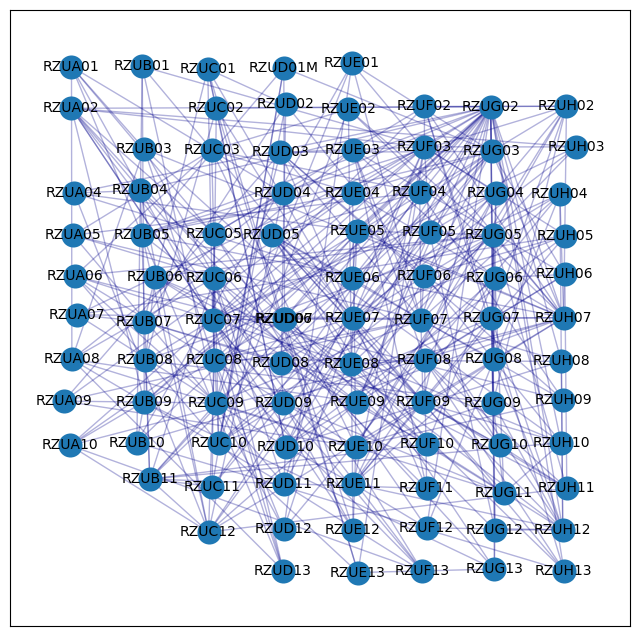

In [54]:
edge_weights = [1 for u, v in G.edges()]
# edge_weights = [sim_mat[u,v]  for u, v in G.edges()]

# Dibujar los nodos del grafo con tamaño personalizado
node_size = 300
# node_color = colores
node_border_color = 'white'
node_border_width = 0
node_labels = {node: df_map.index[node] for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(graphs_[0], positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black', font_size=10)

# escalar los anchos de los enlaces
min_width = 1  # ancho mínimo de enlace
max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo


# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.3) # se puede ver tambien con colores cambiando edge_color=edge_colors
# fig.savefig('./results/graph_geo.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)

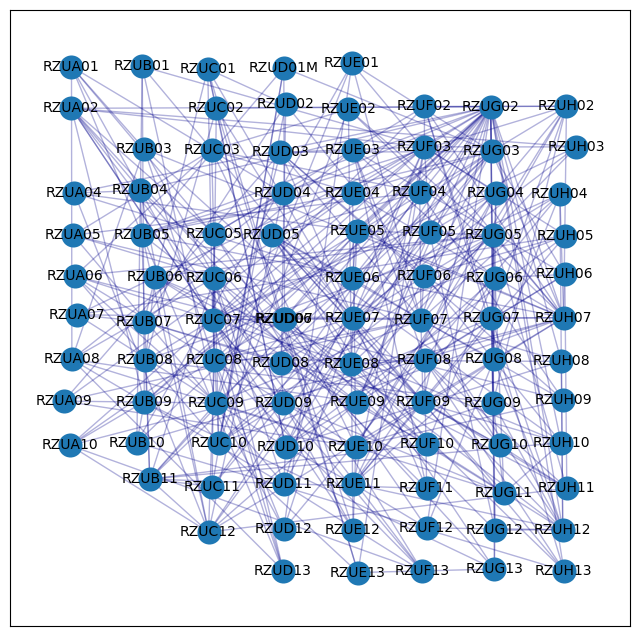

In [55]:
edge_weights = [1 for u, v in G.edges()]

# Dibujar los nodos del grafo con tamaño personalizado
node_size = 300
# node_color = colores
node_border_color = 'white'
node_border_width = 0
node_labels = {node: df_map.index[node] for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(graphs_[0], positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black', font_size=10)

# escalar los anchos de los enlaces
min_width = 1  # ancho mínimo de enlace
max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo


# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.3) # se puede ver tambien con colores cambiando edge_color=edge_colors
# fig.savefig('./results/graph_geo.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)

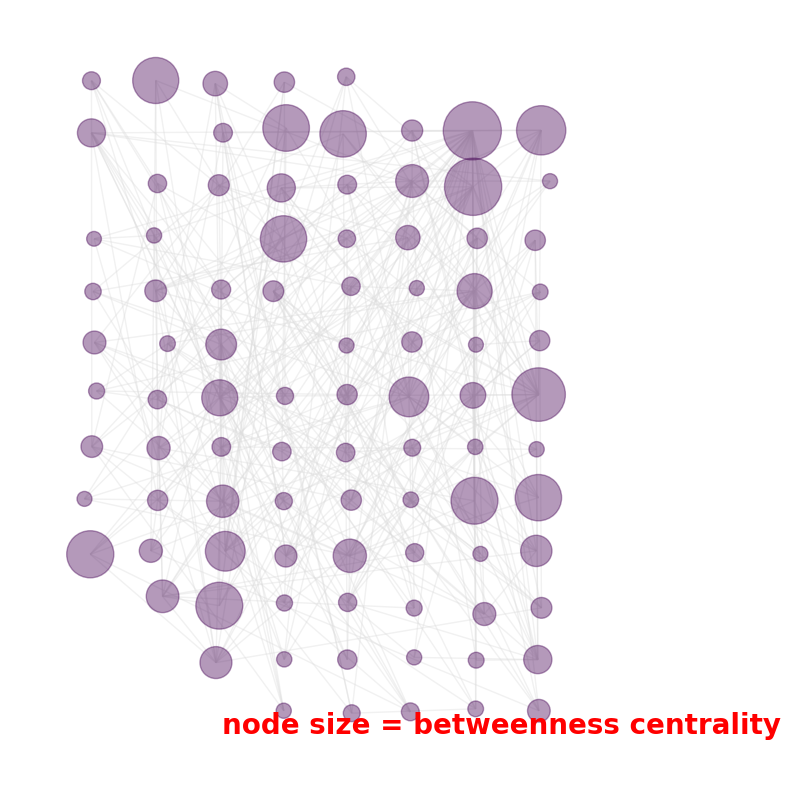

In [56]:
H = G.copy()
H.remove_node(35)
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# # compute community structure
# lpc = nx.community.label_propagation_communities(H)
# community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [0 for n in H]
node_size = [v * 10000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=positions,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "r", "fontweight": "bold", "fontsize": 20}


ax.text(
    0.80,
    0.06,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

In [57]:
from torchsummary import summary
print(summary(model))

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            1,600
├─GCNConv: 1-2                           --
|    └─SumAggregation: 2-1               --
|    └─Linear: 2-2                       4,194,304
├─BatchNorm1d: 1-3                       1,024
├─GCNConv: 1-4                           --
|    └─SumAggregation: 2-3               --
|    └─Linear: 2-4                       8,192
├─GCNConv: 1-5                           --
|    └─SumAggregation: 2-5               --
|    └─Linear: 2-6                       8,192
├─Linear: 1-6                            8,704
├─Linear: 1-7                            1,575,936
├─Sequential: 1-8                        --
|    └─Linear: 2-7                       8,704
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       47,196
├─Sequential: 1-9                        --
|    └─Linear: 2-10                      51
Total params: 5,853,903
Trainable params: 5,853,903
Non-trainable params: 0
Lay

## Fin